Using cuda device
Logging to ./ppo_hologram_tensorboard/PPO_25
-----------------------------
| time/              |      |
|    fps             | 1032 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 747       |
|    iterations           | 2         |
|    time_elapsed         | 5         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 7.08621   |
|    clip_fraction        | 0.898     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.84e+03 |
|    explained_variance   | -0.00995  |
|    learning_rate        | 0.0003    |
|    loss                 | 1.11      |
|    n_updates            | 10        |
|    policy_gradient_loss | 0.0572    |
|    value_loss           | 3.32      |
---------------------------------------
-------

ValueError: Expected parameter logits (Tensor of shape (64, 4096)) of distribution Bernoulli(logits: torch.Size([64, 4096])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

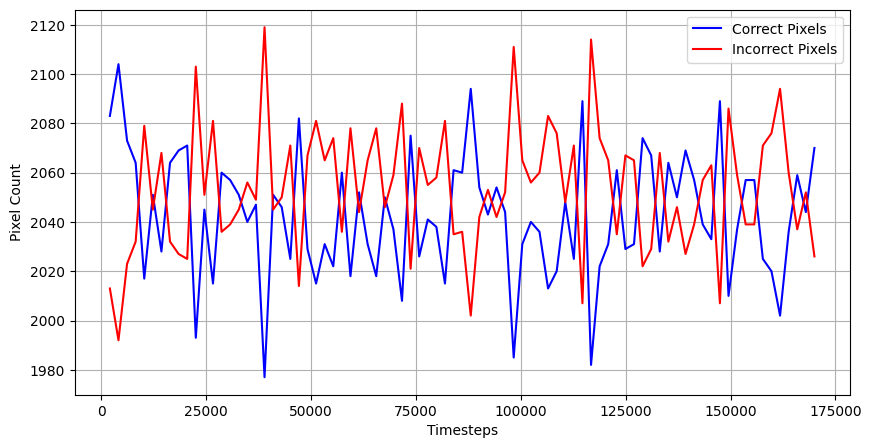

In [9]:
import numpy as np
import gymnasium as gym
from gymnasium.spaces import MultiBinary, Box
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.callbacks import BaseCallback
import torch.nn as nn
import torch
import matplotlib.pyplot as plt


# Custom CNN for feature extraction
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * (observation_space.shape[1] // 4) * (observation_space.shape[2] // 4), features_dim),
            nn.ReLU()
        )

    def forward(self, observations):
        x = self.cnn(observations)
        return self.fc(x)


# Binary Hologram Environment
class BinaryHologramEnv(gym.Env):
    def __init__(self, grid_size=64):
        super(BinaryHologramEnv, self).__init__()
        self.grid_size = grid_size
        self.action_space = MultiBinary(grid_size * grid_size)
        self.observation_space = Box(
            low=0, high=1, shape=(1, grid_size, grid_size), dtype=np.float32
        )
        self.current_state = np.zeros((1, grid_size, grid_size), dtype=np.float32)
        self.target_pattern = self.generate_target_pattern()
        self.step_count = 0
        self.max_steps = 100

    def generate_target_pattern(self):
        return np.random.randint(0, 2, size=(1, self.grid_size, self.grid_size))

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.current_state = np.zeros((1, self.grid_size, self.grid_size), dtype=np.float32)
        self.target_pattern = self.generate_target_pattern()
        self.step_count = 0
        return self.current_state, {}

    def step(self, action):
        action_reshaped = action.reshape((self.grid_size, self.grid_size))
        self.current_state[0] = action_reshaped
        self.step_count += 1

        # Pixel similarity
        correct_pixels = np.sum(self.current_state == self.target_pattern)
        total_pixels = self.grid_size * self.grid_size
        pixel_similarity = correct_pixels / total_pixels
        # Structural similarity (weighted overlap)
        structural_similarity = np.mean(action_reshaped * self.target_pattern[0])
        reward = 0.8 * pixel_similarity + 0.2 * structural_similarity

        terminated = self.step_count >= self.max_steps or pixel_similarity >= 0.95
        truncated = self.step_count >= self.max_steps  # Truncate if max steps are reached

        info = {
            "correct_pixels": correct_pixels,
            "incorrect_pixels": total_pixels - correct_pixels,
        }

        return self.current_state, reward, terminated, truncated, info

    def render(self, mode='human'):
        print(f"Current State:\n{self.current_state[0]}")
        print(f"Target Pattern:\n{self.target_pattern[0]}")


# Custom Callback for plotting
class PixelAccuracyPlotCallback(BaseCallback):
    def __init__(self, eval_freq=1000, verbose=0):
        super(PixelAccuracyPlotCallback, self).__init__(verbose)
        self.eval_freq = eval_freq
        self.correct_pixels = []
        self.incorrect_pixels = []
        self.timesteps = []

        # Initialize plot
        plt.ion()
        self.fig, self.ax = plt.subplots(figsize=(10, 5))

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            infos = self.locals["infos"]
            if len(infos) > 0:
                correct_pixels = infos[0].get("correct_pixels", 0)
                incorrect_pixels = infos[0].get("incorrect_pixels", 0)
                self.correct_pixels.append(correct_pixels)
                self.incorrect_pixels.append(incorrect_pixels)
                self.timesteps.append(self.num_timesteps)

                # Update plot
                self.ax.clear()
                self.ax.plot(self.timesteps, self.correct_pixels, label="Correct Pixels", color="blue")
                self.ax.plot(self.timesteps, self.incorrect_pixels, label="Incorrect Pixels", color="red")
                self.ax.set_xlabel("Timesteps")
                self.ax.set_ylabel("Pixel Count")
                self.ax.legend()
                self.ax.grid(True)
                self.fig.canvas.draw()
                self.fig.canvas.flush_events()
        return True

    def _on_training_end(self) -> None:
        # Close plot on training end
        plt.ioff()
        plt.show()


# Create the environment
def make_env(grid_size=64):
    return DummyVecEnv([lambda: BinaryHologramEnv(grid_size)])


# Instantiate the environment
env = make_env()

# PPO with custom CNN
policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=256),
)

model = PPO(
    "CnnPolicy",
    env,
    policy_kwargs=policy_kwargs,
    gamma=0.99,
    learning_rate=3e-4,
    n_steps=2048,
    verbose=1,
    tensorboard_log="./ppo_hologram_tensorboard/"
)

# Train the model with the callback
callback = PixelAccuracyPlotCallback(eval_freq=2048)
model.learn(total_timesteps=200000, callback=callback)

# Save the model
model.save("ppo_binary_hologram")

# Test the model
test_env = BinaryHologramEnv(grid_size=64)  # 직접 환경 생성
obs, _ = test_env.reset()  # DummyVecEnv 사용하지 않음

for _ in range(100):
    action, _states = model.predict(obs, deterministic=True)
    action = action.reshape((64, 64))  # 모델의 출력을 환경의 기대 형식으로 변환
    obs, reward, terminated, truncated, info = test_env.step(action)

    # 로그 출력
    print(f"Correct Pixels: {info['correct_pixels']}, Incorrect Pixels: {info['incorrect_pixels']}")
    test_env.render()

    if terminated or truncated:
        break
